## Import Dependencies and Data

In [27]:

%load_ext autoreload
%autoreload 1
%aimport utils

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import utils

# Constants
ANALYSIS_PERIOD_YEARS = 20
CONFIDENCE_LEVEL = 0.95
TRADING_DAYS = 252

# Risk Free Rate
tbill: pd.Series = yf.download("^IRX", period="1wk", auto_adjust=False)['Adj Close']
risk_free_rate: float = ((tbill.tail(5).mean() / 100).iloc[0]).round(4)
print(risk_free_rate)

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*ANALYSIS_PERIOD_YEARS)

etfs = ['SPY', 'QQQ', 'SLV', 'UCG.MI']
daily_prices: pd.DataFrame = yf.download(etfs, start=start_date, end=end_date, auto_adjust=False)['Adj Close']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[*********************100%***********************]  1 of 1 completed


0.0378


[*********************100%***********************]  4 of 4 completed


## Weights

We make sure the downloading processes are in a seperate cell so that we don't have to rerun them when changing any variables.

In [28]:
weights = np.array([0.5, 0.2, 0.15, 0.15])

## Data Cleaning and Preparation

In [29]:
daily_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5162 entries, 2005-11-21 to 2025-11-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   QQQ     5027 non-null   float64
 1   SLV     4919 non-null   float64
 2   SPY     5027 non-null   float64
 3   UCG.MI  5077 non-null   float64
dtypes: float64(4)
memory usage: 201.6 KB


In [30]:
daily_prices.head()

Ticker,QQQ,SLV,SPY,UCG.MI
Date,,,,
2005-11-21,35.522591,NaN,86.611771,83.153015
2005-11-22,35.650829,NaN,86.983665,83.386360
2005-11-23,35.736332,NaN,87.486420,84.086426
2005-11-24,NaN,NaN,NaN,83.541916
2005-11-25,35.813282,NaN,87.555290,83.230774


We can see that SLV started later than the other securities. Also, UCG is traded in Italy, therefore there are mismatches on trading dates with the US-traded ETFs.

We can't fill data gaps from when a security was unlisted, so we will drop all rows until it's inception.

In [31]:
latest_inception: pd.Timestamp = daily_prices['SLV'].first_valid_index()
daily_prices: pd.DataFrame = daily_prices[latest_inception:]
daily_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5049 entries, 2006-04-28 to 2025-11-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   QQQ     4919 non-null   float64
 1   SLV     4919 non-null   float64
 2   SPY     4919 non-null   float64
 3   UCG.MI  4965 non-null   float64
dtypes: float64(4)
memory usage: 197.2 KB


All that is left now is the trading days mismatches. We will fill these missing data with the mean of the previous and next value.

In [32]:
daily_prices[daily_prices.isna().any(axis=1)]

# Will be empty if they trade on the same exchange.

Ticker,QQQ,SLV,SPY,UCG.MI
Date,,,,
2006-05-01,35.538929,13.870000,90.642448,NaN
2006-05-29,NaN,NaN,NaN,96.765511
2006-07-04,NaN,NaN,NaN,99.265274
2006-08-15,32.353260,12.105000,89.807335,NaN
2006-09-04,NaN,NaN,NaN,101.119942
...,...,...,...,...
2025-07-04,NaN,NaN,NaN,56.450001
2025-08-15,576.671509,34.500000,641.661072,NaN
2025-09-01,NaN,NaN,NaN,66.699997


In [33]:
daily_prices: pd.DataFrame = daily_prices.interpolate(method='linear') # filling missing data with weighted average of previous and next available price
daily_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5049 entries, 2006-04-28 to 2025-11-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   QQQ     5049 non-null   float64
 1   SLV     5049 non-null   float64
 2   SPY     5049 non-null   float64
 3   UCG.MI  5049 non-null   float64
dtypes: float64(4)
memory usage: 197.2 KB


Both `geometric_portfolio_returns` and `standard_deviation` functions need daily returns, not daily prices. It is, therefore, good practice to calculate the returns **once** and pass them into the functions, rather than calculating it inside each function.

In [34]:
daily_returns: pd.DataFrame = daily_prices.pct_change().dropna()

## Expected returns calculation

In [35]:
average_annual_return: float
annual_returns: pd.Series
average_annual_return, annual_returns = utils.portfolio_returns(daily_returns, weights)
annual_returns

Date
2006    0.060187
2007    0.123644
2008   -0.393535
2009    0.538221
2010    0.215807
2011   -0.089713
2012    0.142727
2013    0.197755
2014    0.081361
2015    0.028441
2016    0.024724
2017    0.236098
2018   -0.078038
2019    0.339600
2020    0.283375
2021    0.267167
2022   -0.174741
2023    0.441083
2024    0.318555
2025    0.382578
dtype: float64

## CAGR

In [36]:
daily_prices

Ticker,QQQ,SLV,SPY,UCG.MI
Date,,,,
2006-04-28,35.890553,13.812000,91.386230,92.876228
2006-05-01,35.538929,13.870000,90.642448,93.576298
2006-05-02,35.633270,14.365000,91.323677,94.276367
2006-05-03,35.581829,13.925000,90.983093,94.587517
2006-05-04,35.873405,14.000000,91.309792,94.587517
...,...,...,...,...
2025-11-10,623.229980,45.790001,681.440002,65.599998
2025-11-11,621.570007,46.450001,683.000000,66.639999
2025-11-12,621.080017,48.320000,683.380005,68.059998


In [37]:
cagr = utils.cagr(daily_prices, weights)
print(f"CAGR: {cagr:.2%}")

CAGR: 124.40%


## Standard Deviation and Covariance

In [38]:
annualized_std, daily_std = utils.standard_deviation(daily_returns, weights)
print(f"{annualized_std:.2%}")
print(f"{daily_std:.2%}")

19.36%
1.22%


## Sharpe Ratio

In [39]:
sharpe_ratio = (average_annual_return-risk_free_rate)/annualized_std
print(f"{sharpe_ratio:.3}")


0.565


## Maximum Drawdown

In [40]:
cumul_prod = (1 + daily_returns).cumprod()*100
running_peak = cumul_prod.expanding().max() # expanding().max() calculates max first for 1st value, then 1st and 2nd, then 1,2,3... then 1 to n 
drawdowns = (cumul_prod/running_peak)-1
max_drawdown = drawdowns.min() @ weights # obviously not .max() since you work with negative values
print(f"Max drawdown: {max_drawdown:.2%}")

Max drawdown: -64.72%


In [41]:
print("\nPortfolio Analysis Results:")
print("-" * 50)
print(f"Expected Annual Return: {average_annual_return:.2%}")
print(f"Annualized Standard Deviation: {annualized_std:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

print(f"Risk Free Rate: {risk_free_rate:.2%}")

# print("\nRisk Metrics:")
# print(f"1-Year VaR: There is a {(1-CONFIDENCE_LEVEL)*100:.1f}% chance that the portfolio loss")
# print(f"           will exceed {annual_var*100:.2f}% in 1 year.")
# print(f"1-Year CVaR: If the loss exceeds the VaR, the average loss is {annual_cvar*100:.2f}%")
# print(f"            in 1 year.")


Portfolio Analysis Results:
--------------------------------------------------
Expected Annual Return: 14.73%
Annualized Standard Deviation: 19.36%
Sharpe Ratio: 0.565
Maximum Drawdown: -64.72%
Risk Free Rate: 3.78%


## Price Histograms

array([[<Axes: title={'center': 'QQQ'}>, <Axes: title={'center': 'SLV'}>],
       [<Axes: title={'center': 'SPY'}>,
        <Axes: title={'center': 'UCG.MI'}>]], dtype=object)

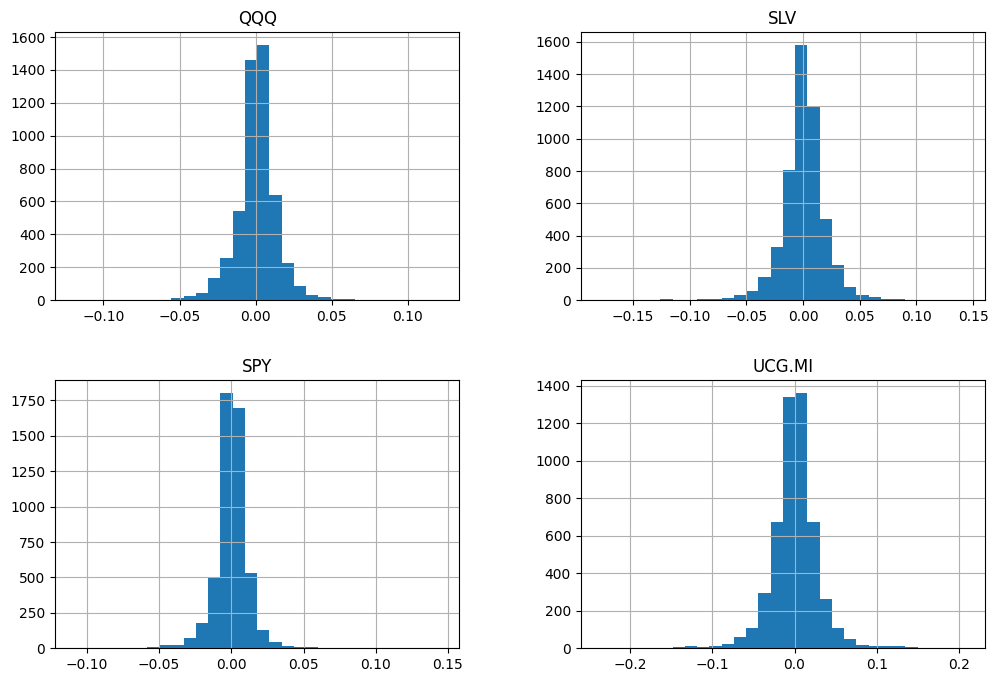

In [42]:
daily_returns.hist(figsize=(12,8), grid = True, bins=30)

## Cumulative Returns Time-Series Plot

In [62]:
# We will turn our data to weekly for the graph to look smoother.

weekly_prices = daily_prices.resample('W').last()
weekly_returns = weekly_prices.pct_change().dropna()
cumul_prod_weekly = (1 + daily_returns).cumprod() - 1

<Axes: xlabel='Date'>

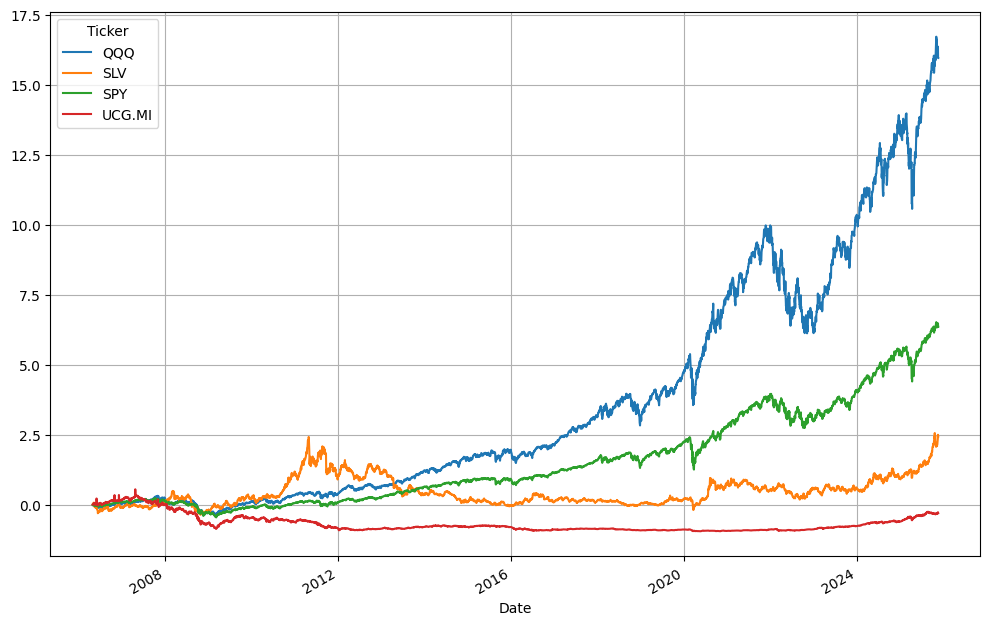

In [63]:
cumul_prod_weekly.plot(figsize=(12,8), grid=True)

## VaR coming soon